# Imports:

In [10]:
import os
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.utils import load_img, img_to_array

In [11]:
def get_images(directory):
    """Read all images """
    files = os.listdir(directory)
    img_list = []

    for file_name in files:
        if file_name.endswith(".png"):
            img_path = directory + file_name
            img = load_img(img_path, target_size=(150, 150))
            img = img_to_array(img, dtype='float32')
            img_list.append(img)
    
    return np.array(img_list)

def rotate_images(images_to_rotate):
    rotation_list = []
    type(rotation_list)
    for i in range(3):
        rotated_images = []
        for img in images_to_rotate:
            rot_img = np.rot90(img)
            rotated_images.append(rot_img)
        
        rotated_images = np.array(rotated_images)
        images_to_rotate = rotated_images
        rotation_list.append(rotated_images)
        
    return rotation_list[0], rotation_list[1], rotation_list[2]

def normalize(array):
    """Normalizes the supplied array of images."""
    array = array.astype("float32") / 255.0
    return array

def add_noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.2
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

def display(array1, array2, array3, n):
    """Displays n random images from each array."""
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 = array3[indices, :]
    
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(image1)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(image3)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

# Preprocessing images

(209, 150, 150, 3)
(209, 150, 150, 3)


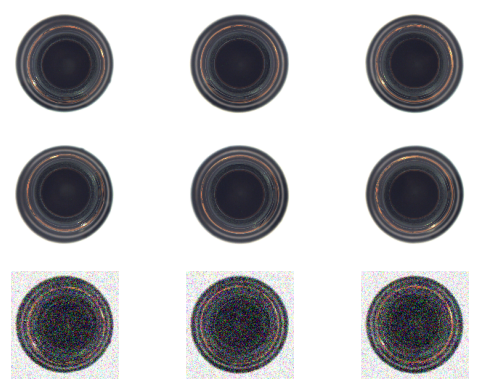

In [12]:
data_directory = "../dataset/bottle/train/good/"
broken_path = "../dataset/bottle/test/broken_large/000.png"

images = get_images(data_directory) # Read all images from data_directory
print(images.shape)
images = normalize(images)          # Normalize the pixel values from integer values [0, 255] to float [0, 1]
rotated_90, rotated_180, rotated_270 = rotate_images(images)
print(rotated_90.shape)
noisy_images = add_noise(images)    # Add noise to every images in images and store in a separate list


display(images, rotated_90, noisy_images, 3)